## Setup environment

In [3]:
import os

# Set the environment variable to allow duplicate OpenMP libraries
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [4]:
!python -c "import monai" || pip install -q "monai-weekly[ignite, tqdm, tensorboard]"

/bin/bash: /app/miniconda/24.11.1/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [5]:
!pip install lightning matplotlib tensorboard

/bin/bash: /app/miniconda/24.11.1/lib/libtinfo.so.6: no version information available (required by /bin/bash)


## Setup Import

In [6]:
import requests
import zipfile
from pathlib import Path

import os
import csv
import logging
import torch
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from monai.transforms import Compose, LoadImageD, EnsureChannelFirstD, ScaleIntensityD, ResizeD,RandZoomD
from monai.networks.nets import densenet121
from torchmetrics.classification import Accuracy

## Download Dataset

In [7]:
def download_and_unzip(url, extract_path):
    # Download the ZIP file
    response = requests.get(url, stream=True)
    with open('temp.zip', 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:  # filter out keep-alive new chunks
                file.write(chunk)

    # Unzip the downloaded file
    with zipfile.ZipFile('temp.zip', 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    # Remove the temporary ZIP file
    import os
    os.remove('temp.zip')

# Example usage:
url = "https://wistify.b-cdn.net/website-resources/DR_short.zip"
extract_path = "unzipped_files"
download_and_unzip(url, extract_path)

# change root path
root_dir = Path("unzipped_files")
print(root_dir)

unzipped_files


## Set dataset root directory

In [8]:
# Set logging
logging.basicConfig(level=logging.INFO)

# Function to generate data list dynamically
def generate_data_list(root_dir, section):
    """
    Generate a list of dictionaries for each data sample, including the filename and label.
    """
    data_list = []
    section_dir = os.path.join(root_dir, section)
    if not os.path.isdir(section_dir):
        raise ValueError(f"Section directory {section_dir} does not exist.")
    for grade_folder in os.listdir(section_dir):
        grade_path = os.path.join(section_dir, grade_folder)
        if os.path.isdir(grade_path):
            label = int(grade_folder.split("_")[1])  # Extract label from folder name
            for image_file in os.listdir(grade_path):
                if image_file.endswith(".png"):
                    image_path = os.path.join(grade_path, image_file)
                    data_list.append({"image": image_path, "label": label, "filename": image_file})  # Add filename
    return data_list


# Root directory for dataset
root_dir = "unzipped_files/DR"

# Load data
train_data_list = generate_data_list(root_dir, "train")
val_data_list = generate_data_list(root_dir, "val")
test_data_list = generate_data_list(root_dir, "test")



## Check VRAM Usage

In [9]:
# Check initial VRAM usage
initial_vram = torch.cuda.memory_allocated()
print(f"Initial VRAM usage: {initial_vram / 1024**2:.2f} MB")

!nvidia-smi

Initial VRAM usage: 0.00 MB
/bin/bash: /app/miniconda/24.11.1/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Sun Nov  9 22:05:50 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.03             Driver Version: 535.216.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:07:00.0 Off |                   On |
| N/A   30C    P0              53W / 400W |     87MiB / 81920MiB |     N/A      Default |
|                   

## Setup dataloader

In [10]:
from monai.data import Dataset

# Define transformations
transforms = Compose([
    LoadImageD(keys="image", image_only=True),
    EnsureChannelFirstD(keys="image"),
    ScaleIntensityD(keys="image"),
    ResizeD(keys="image", spatial_size=(256, 256)),
    RandZoomD(keys="image", min_zoom=0.9, max_zoom=1.1, prob=0.5)
])

# Create MONAI datasets
train_dataset = Dataset(data=train_data_list, transform=transforms)
val_dataset = Dataset(data=val_data_list, transform=transforms)
test_dataset = Dataset(data=test_data_list, transform=transforms)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Train samples: 80
Validation samples: 20
Test samples: 20


## Setup Pytorch Lightning Module for Training DR

In [11]:
from torchmetrics.classification import MulticlassAccuracy

class DRModel(pl.LightningModule):
    def __init__(self, num_classes=5, lr=1e-5):
        super(DRModel, self).__init__()
        self.model = densenet121(spatial_dims=2, in_channels=3, out_channels=num_classes)
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.train_accuracy = MulticlassAccuracy(num_classes=num_classes)
        self.val_accuracy = MulticlassAccuracy(num_classes=num_classes)
        self.test_accuracy = MulticlassAccuracy(num_classes=num_classes)
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["label"]
        outputs = self(images)
        loss = self.loss_fn(outputs, labels)
        acc = self.train_accuracy(outputs, labels)
        self.log("train_loss", loss)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["label"]
        outputs = self(images)
        loss = self.loss_fn(outputs, labels)
        acc = self.val_accuracy(outputs, labels)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["label"]
        outputs = self(images)
        acc = self.test_accuracy(outputs, labels)
        self.log("test_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

## Set hyperparameters and Start Training

In [12]:
# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="./eval",
    filename="best-checkpoint",
    save_top_k=1,
    mode="min",
)
early_stopping = EarlyStopping(monitor="val_loss", patience=3, mode="min")

# Logger
logger = TensorBoardLogger("lightning_logs", name="DR_classification")

# Train
model = DRModel()
trainer = pl.Trainer(
    # max_epochs=10,
    max_epochs=3,  # Set to 3 for a quick demo session
    # accelerator="cpu",
    accelerator="gpu",
    devices=1,
    logger=logger,
    callbacks=[checkpoint_callback, early_stopping],
    log_every_n_steps=10,
)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

# Test
trainer.test(model, dataloaders=test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB MIG 3g.40gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/scr/user/qmedasia/monai/lib/python3.13/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /scr/user/qmedasia/.bootcamp/monai/nvidia_monai_worksop_1/1_Classification_2D/eval exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | DenseNet121        | 7.0 M  | train
1 | loss_fn        | CrossEntropyLoss   | 0      | tra

/scr/user/qmedasia/monai/lib/python3.13/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 20. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/scr/user/qmedasia/monai/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 2/2 [00:21<00:00,  0.09it/s, v_num=3, train_acc=0.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 2/2 [00:21<00:00,  0.09it/s, v_num=3, train_acc=0.200, val_loss=1.600, val_acc=0.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 2/2 [00:23<00:00,  0.09it/s, v_num=3, train_acc=0.000, val_loss=1.610, val_acc=0.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 2/2 [00:31<00:00,  0.06it/s, v_num=3, train_acc=0.000, val_loss=1.610, val_acc=0.200]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 2/2 [00:31<00:00,  0.06it/s, v_num=3, train_acc=0.000, val_loss=1.610, val_acc=0.200]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.20000000298023224
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.20000000298023224}]

## Tensorboard to show the training loss and validation loss

- Vist `http://10.11.132.43:8008/` in the browser for the visualization of the tensorboard.

In [16]:
# %reload_ext tensorboard
%load_ext tensorboard
%tensorboard --logdir lightning_logs --host 0.0.0.0 --port 8008

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Check Final VRAM Usage

In [14]:
final_vram = torch.cuda.max_memory_allocated()
print(f"Final Peak VRAM during training: {final_vram / 1024**2:.2f} MB")

print(f"Current VRAM: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

!nvidia-smi

Final Peak VRAM during training: 10601.49 MB
Current VRAM: 80.11 MB
/bin/bash: /app/miniconda/24.11.1/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Sun Nov  9 22:07:46 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.03             Driver Version: 535.216.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:07:00.0 Off |                   On |
| N/A   30C    P0              53W / 400W |     87MiB / 81920MiB |    

## Load the saved checkpoint and perform inference with visualization

Image path: /scr/user/qmedasia/.bootcamp/monai/nvidia_monai_worksop_1/1_Classification_2D/unzipped_files/DR/test/Grade_4/3b4a5fcbe5e0.png


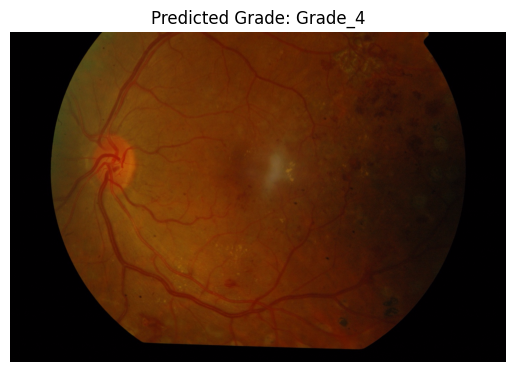

Prediction for /scr/user/qmedasia/.bootcamp/monai/nvidia_monai_worksop_1/1_Classification_2D/unzipped_files/DR/test/Grade_4/3b4a5fcbe5e0.png: Grade_4


In [15]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from monai.transforms import Compose, LoadImageD, EnsureChannelFirstD, ScaleIntensityD, Resized
import os

# Class names for predictions
class_names = ['Grade_0', 'Grade_1', 'Grade_2', 'Grade_3', 'Grade_4']

# Define the transforms (reuse from training)
test_transforms = Compose([
    LoadImageD(keys="image"),
    EnsureChannelFirstD(keys="image"),
    ScaleIntensityD(keys="image"),
    Resized(keys="image", spatial_size=(256, 256))
])

# Get the current working directory
current_directory = os.getcwd()

# Define the image path components
image_path = os.path.join(current_directory, "unzipped_files", "DR", "test", "Grade_4", "3b4a5fcbe5e0.png")


print(f"Image path: {image_path}")

# Load the image and apply transformations
image_data = {"image": image_path}
transformed = test_transforms(image_data)
image_tensor = transformed["image"].unsqueeze(0).to(model.device)  # Add batch dimension

# Perform inference
model.eval()
with torch.no_grad():
    output = model(image_tensor)
    predicted_class = torch.argmax(output, dim=1).item()

# Visualize the image and prediction
img = Image.open(image_path)
plt.imshow(img)
plt.title(f"Predicted Grade: {class_names[predicted_class]}")
plt.axis("off")
plt.show()

# Print prediction
print(f"Prediction for {image_path}: {class_names[predicted_class]}")